

# <center> Explicable Intelligence Artificielle - XAI</center>
#### <center> Initially prepared by Peerasu Watanasirang, Kasetsart University, Thailand 2021-2022</center>
#### <center>  Updated by Lina Fahed, 2023</center>


***

# Application of SHAP on ResNet50 dataset

In [1]:
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import shap
import os

2025-02-18 16:40:08.336016: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-18 16:40:08.371118: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Loading Model and Data

In [2]:
# Specify a custom cache directory
custom_cache_dir = '/imt-atl/ILSD/advanced-machine-learning/labs/lab-02/solution/XAI-tutorials/SHAP-on-Images-ResNet50'
os.makedirs(custom_cache_dir, exist_ok=True)

# Set the environment variable to use the custom cache directory
os.environ['SHAP_CACHE_DIR'] = custom_cache_dir

In [3]:
# load pre-trained model and data
model = ResNet50(weights='imagenet')
X, y = shap.datasets.imagenet50()

PermissionError: [Errno 13] Permission denied: '/usr/lib/python3.13/site-packages/shap/cached_data'

In [3]:
# getting ImageNet 1000 class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
with open(shap.datasets.cache(url)) as file:
    class_names = [v[1] for v in json.load(file).values()]
#print("Number of ImageNet classes:", len(class_names))
#print("Class names:", class_names)

## Applying SHAP on ResNet50 for images

Build a partition explainer with: 
- the model (a python function) 
- the masker (a python function) 
- output names (a list of names of the output classes)

### A quick run with a few evaluations

In [4]:
# python function to get model output; replace this function with your own model function.
def f(x):
    tmp = x.copy()
    preprocess_input(tmp)
    return model(tmp)

# define a masker that is used to mask out partitions of the input image.
masker = shap.maskers.Image("inpaint_telea", X[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(f, masker, output_names=class_names)

# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(X[1:5], max_evals=100, batch_size=50, outputs=shap.Explanation.argsort.flip[:4])

explainers.Partition is still in an alpha state, so use with caution...


Partition explainer:  50%|█████     | 2/4 [00:00<?, ?it/s]

Partition explainer: 100%|██████████| 4/4 [00:28<00:00,  4.61s/it]

Partition explainer: 5it [00:37, 12.40s/it]                       


#### Explainer options:
> 1. Above image masker uses a blurring technique called “inpaint_telea”. There are alternate masking options available to experiment with such as “inpaint_ns” and “blur(kernel_xsize, kernel_xsize)”.

> 2. Recommended number of evaluations is 300-500 to get explanations with sufficient granularity for the super pixels. More the number of evaluations, more the granularity but also increases run-time.

> Note: outputs=shap.Explanation.argsort.flip[:4] has been used in the code above for getting SHAP values because we want to get the top 4 most probable classes for each image i.e. top 4 classes with decreasing probability. Hence, a flip argsort sliced by 4 has been used.

## Visualizing SHAP values output

In this visualization:

- Red pixels represent positive SHAP values that contributed to classifying that image as that particular class.
- Blue pixels represent negative SHAP values that contributed to not classifying that image as that particular class.


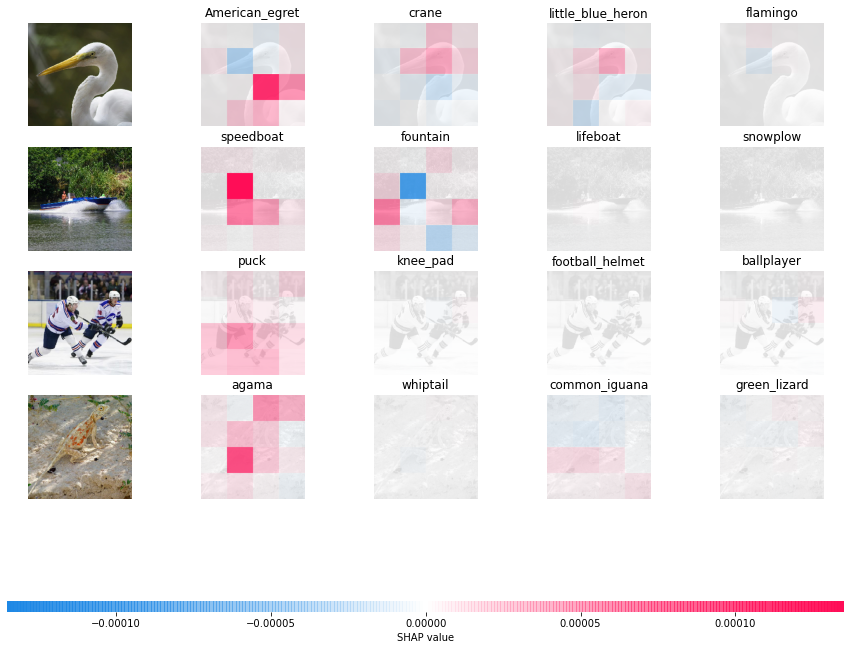

In [5]:
# output with shap values
shap.image_plot(shap_values)

> 1. In the first example, given bird image is classified as an American Egret with next probable classes being a Crane, Heron and Flamingo. It is the “bump” over the bird’s neck that causes it to be classified as an American Egret vs a Crane, Heron or a Flamingo. You can see the neck region of the bird appropriately highlighted in red super pixels.

> 2. In the second example, it is the shape of the boat with a man driving it, which causes it to be classified as a speedboat instead of a fountain, lifeboat or snowplow (appropriately highlighted in red super pixels).

> 3. In the third example, given puck hockey image is classified as a knee pad, football helmet, and a ballplayer. the area where it can be classified as puck hockey is around the "leg" of the hockey's player. They both wear the hockey shoes. You can see the region in red super pixels around both hockey player legs.

> 4. In the fourth example, we have a lizard image that is classified as an Agama. Comparing to other three images that are whiptail, common iguana, and green lizard. It is the colorful "body" and "head" section of the lizard that causes it to be classified as an agama. You can see around the area that I told is already highlighted in red super pixels, which means the SHAP value is high in that area.